In [18]:
def getCupLocation2D_RED(fname):
    low_H = 0.011 * 180
    low_S = 0.658 * 255
    low_V = 0.545 * 255
    high_H = 0.034 * 180
    high_S = 0.816 * 255
    high_V = 0.773 * 255
    img = cv2.imread(fname)

    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_threshold = cv2.inRange(img_HSV, (low_H, low_S, low_V), (high_H, high_S, high_V))
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_threshold, 4, cv2.CV_32S)

    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    # find component with largest area (excluding first component)
    cup_label = np.argmax(stats[1:,4]) + 1 

    return labeled_img, centroids[cup_label]

def getCupLocation2D_GREEN(fname):
    low_H = 0.282 * 180
    low_S = 0.450 * 255
    low_V = 0.478 * 255
    high_H = 0.351 * 180
    high_S = 0.574 * 255
    high_V = 0.655 * 255
    img = cv2.imread(fname)

    img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_threshold = cv2.inRange(img_HSV, (low_H, low_S, low_V), (high_H, high_S, high_V))
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_threshold, 4, cv2.CV_32S)

    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    # find component with largest area (excluding first component)
    cup_label = np.argmax(stats[1:,4]) + 1 

    return labeled_img, centroids[cup_label]

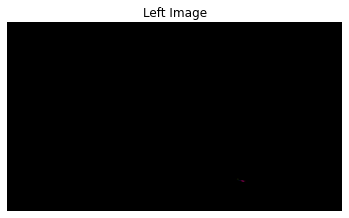

In [25]:
labeled_img1, x1 = getCupLocation2D_RED('calibration/calibration_picture/up1.jpg')
labeled_img2, x2 = getCupLocation2D_GREEN('calibration/calibration_picture/up1.jpg')
# show image for left camera
plt.imshow(cv2.cvtColor(labeled_img1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Left Image")
plt.show()
center_up = (x1+x2)/2


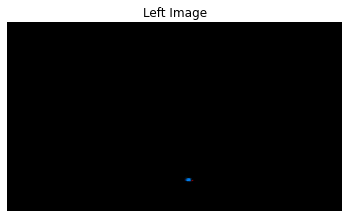

In [26]:
labeled_img1, x1 = getCupLocation2D_RED('calibration/calibration_picture/down1.jpg')
labeled_img2, x2 = getCupLocation2D_GREEN('calibration/calibration_picture/down1.jpg')
# show image for left camera
plt.imshow(cv2.cvtColor(labeled_img1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Left Image")
plt.show()
center_down = (x1+x2)/2


In [29]:
from triangulation import triangulate
triangulate(np.array([center_up], np.float32), np.array([center_down], np.float32))
cam2arm = np.matmul(cup_coord, np.linalg.inv(observed_points))

array([[ -61.125275],
       [ -95.59628 ],
       [-369.0976  ]], dtype=float32)

In [2]:
def get_center(mask):
    minx = 99999
    miny = 99999
    maxx = -1
    maxy = -1
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] == True:
                if i<minx:
                    minx = i
                if i>maxx:
                    maxx = i
                if j<miny:
                    miny = j
                if j>maxy:
                    maxy = j
    return np.array(np.round([(maxx+minx)/2, (maxy+miny)/2]).astype(int))

def get_center_mean(mask):
    xsum = 0
    ysum = 0
    point_count = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] == True:
                xsum+=i
                ysum+=j
                point_count+=1
    return np.array(np.round([xsum/point_count, ysum/point_count]).astype(int))

In [16]:
import cv2
import numpy as np

## Read
img = cv2.imread('calibration/calibration_picture/up1.jpg')
#img = cv2.imread("circle_RG.png")

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

low_H = 0.011 * 180
low_S = 0.658 * 255
low_V = 0.545 * 255
high_H = 0.034 * 180
high_S = 0.816 * 255
high_V = 0.773 * 255

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask_red = cv2.inRange(hsv, (low_H, low_S, low_V), (high_H, high_S, high_V))

low_H = 0.282 * 180
low_S = 0.450 * 255
low_V = 0.478 * 255
high_H = 0.351 * 180
high_S = 0.574 * 255
high_V = 0.655 * 255

mask_green = cv2.inRange(hsv, (low_H, low_S, low_V), (high_H, high_S, high_V))
## slice the red
imask_red = mask_red>0
red = np.zeros_like(img, np.uint8)
red[imask_red] = img[imask_red]
center_red = get_center_mean(imask_red)
red[center_red[0], center_red[1]] = np.array([255,255,255])

## slice the green
imask_green = mask_green>0
green = np.zeros_like(img, np.uint8)
green[imask_green] = img[imask_green]
center_green = get_center_mean(imask_green)
green[center_green[0], center_green[1]] = np.array([255,255,255])
center_jenga = np.array(np.round([(center_green[0]+center_red[0])/2, (center_green[1]+center_red[1])/2]).astype(int))

final = np.zeros_like(img, np.uint8)
final[imask_red] = red[imask_red]
final[imask_green] = green[imask_green]
final[center_jenga[0], center_jenga[1]] = np.array([255,255,0])
## save
#final = cv2.putText(final, 'green', (center_green[0], center_green[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.imwrite("center_test.png", final)
center_L = center_jenga


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [32]:
import cv2
import numpy as np

## Read
img = cv2.imread("circles/circle1_R.jpeg")
#img = cv2.imread("circle_RG.png")

## convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

low_H = 0.011 * 180
low_S = 0.658 * 255
low_V = 0.545 * 255
high_H = 0.034 * 180
high_S = 0.816 * 255
high_V = 0.773 * 255

## mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
mask_red = cv2.inRange(hsv, (low_H, low_S, low_V), (high_H, high_S, high_V))

low_H = 0.282 * 180
low_S = 0.450 * 255
low_V = 0.478 * 255
high_H = 0.351 * 180
high_S = 0.574 * 255
high_V = 0.655 * 255

mask_green = cv2.inRange(hsv, (low_H, low_S, low_V), (high_H, high_S, high_V))
## slice the red
imask_red = mask_red>0
red = np.zeros_like(img, np.uint8)
red[imask_red] = img[imask_red]
center_red = get_center_mean(imask_red)
red[center_red[0], center_red[1]] = np.array([255,255,255])

## slice the green
imask_green = mask_green>0
green = np.zeros_like(img, np.uint8)
green[imask_green] = img[imask_green]
center_green = get_center_mean(imask_green)
green[center_green[0], center_green[1]] = np.array([255,255,255])
center_jenga = np.array(np.round([(center_green[0]+center_red[0])/2, (center_green[1]+center_red[1])/2]).astype(int))

final = np.zeros_like(img, np.uint8)
final[imask_red] = red[imask_red]
final[imask_green] = green[imask_green]
final[center_jenga[0], center_jenga[1]] = np.array([255,255,0])
## save
#final = cv2.putText(final, 'green', (center_green[0], center_green[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.imwrite("centers_R.png", final)
center_R = center_jenga


In [ ]:
vis = np.zeros((384, 836), np.float32)
h,w = vis.shape
vis2 = cv.CreateMat(h, w, cv.CV_32FC3)
vis0 = cv.fromarray(vis)

In [7]:
# %matplotlib notebook

import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
